In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

C:\Users\Edward\AppData\Local\Temp\ipykernel_24376\2514361820.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Train Test split
Total 25 million rows <br>
Split 0.8 Train : 0.2 Test

In [2]:
test_index = range(10_000_000,15_000_000+1)

In [3]:
chunksize = 1000000
sliding_window_data = pd.read_csv("sliding_window_data.csv", chunksize=chunksize, iterator=True, skiprows=test_index)

#### Setting Seed value

In [4]:
seed = 3101
np.random.seed(3101)

In [5]:
regression_model = PassiveAggressiveRegressor(random_state=seed, shuffle=True)
for batch in tqdm(sliding_window_data):
    drop_cols = ["date","time","station"]
    for i in range(1,7):
        for j in range(1,7):
            drop_cols.append(f"T{i}S{j}_station number")
    batch.drop(drop_cols, axis=1, inplace=True)
    batch.fillna(value=0, inplace=True)
    regression_model.partial_fit(batch.iloc[:,1:], batch.iloc[:,0])

21it [15:31, 44.35s/it]


In [6]:
def display_metrics(y_pred,y_true):
    print(f'R2 score is : {sm.r2_score(y_true,y_pred)}')
    print(f'MAE is : {sm.mean_absolute_error(y_true,y_pred)}')
    print(f'MSE is : {sm.mean_squared_error(y_true,y_pred)}')
    
    threshold = 0.0
    result = pd.DataFrame({'predicted': y_pred, 'actual': y_true}, columns=['predicted', 'actual'])
    result
    fn = result[result['actual'] > threshold]
    fn = fn[round(fn['predicted'],1) <= threshold]
    fnr = len(fn)/len(result[result['actual'] > threshold])
    print(f'False negative rate is : {fnr}')

    fp = result[result['actual'] == threshold]
    fp = fp[round(fp['predicted'],1) > threshold]
    fpr = len(fp)/len(result[result['actual'] == threshold])
    print(f'False positive rate (FP/FP+TN) is : {fpr}')

In [7]:
test_dataset = pd.read_csv("sliding_window_data.csv", header=0, nrows=5_000_000, skiprows=range(1,10_000_000))
drop_cols = ["date","time","station"]
for i in range(1,7):
    for j in range(1,7):
        drop_cols.append(f"T{i}S{j}_station number")
test_dataset.drop(drop_cols, axis=1, inplace=True)
test_dataset.fillna(value=0, inplace=True)

In [8]:
prediction_base = regression_model.predict(test_dataset.iloc[:,1:])

In [9]:
display_metrics(prediction_base,test_dataset.iloc[:,0])

R2 score is : -0.021399897507405896
MAE is : 0.1137264995162555
MSE is : 0.07751863237041332
False negative rate is : 0.006280711094484054
False positive rate (FP/FP+TN) is : 0.9987685668986421


#### Hyper parameter tuning

In [46]:
sample_size = 2000000
sample_data = pd.read_csv("sliding_window_data.csv", header=0, nrows=sample_size, skiprows=range(1,3101888))

In [47]:
drop_cols = ["date","time","station"]
for i in range(1,7):
    for j in range(1,7):
        drop_cols.append(f"T{i}S{j}_station number")
sample_data.drop(drop_cols, axis=1, inplace=True)
sample_data.fillna(value=0, inplace=True)

In [48]:
train, test = train_test_split(sample_data, test_size=0.2, random_state=seed, shuffle=True)

In [49]:
train.iloc[:,0].values

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
par = PassiveAggressiveRegressor(random_state=seed, shuffle=True)
param_list = {"C":[0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}

gridCV = GridSearchCV(estimator=par, param_grid=param_list, verbose=10, return_train_score=True, n_jobs=10, refit=True)
gridCV.fit(train.iloc[:,1:].values, train.iloc[:,0].values)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=PassiveAggressiveRegressor(random_state=3101), n_jobs=10,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]},
             return_train_score=True, verbose=10)

In [51]:
gridCV.cv_results_

{'mean_fit_time': array([140.00676675, 232.16033106,  41.2871768 ,  32.2199295 ,
         27.02188406,  21.62916765,  14.64967709]),
 'std_fit_time': array([73.0610917 , 60.85381696,  3.82128928, 10.76089808,  5.13222943,
         5.31280306,  5.2167164 ]),
 'mean_score_time': array([4.43432217, 3.07508221, 0.42871757, 0.70129609, 2.45876045,
        1.4311995 , 0.19010077]),
 'std_score_time': array([3.03711246, 2.7261403 , 0.12104769, 0.52798516, 3.71874702,
        2.08347441, 0.01836753]),
 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1.0},
  {'C': 1.5},
  {'C': 2.0}],
 'split0_test_score': array([-0.09911644, -0.09911644, -0.09911644, -0.09911644, -0.09911644,
        -0.09911644, -0.09911644]),
 'split1_test_score': array([0.0013623, 0.0013623, 0.0013623, 0.00136

In [54]:
gridCV.best_params_

{'C': 0.01}

#### Fitting a new Passive Aggressive Regressor with the best params from hyperparamater tuning

#### Re-generate train dataset iterator

In [10]:
sliding_window_data = pd.read_csv("sliding_window_data.csv", chunksize=chunksize, iterator=True, skiprows=test_index)

In [11]:
regression_model_hyper = PassiveAggressiveRegressor(C=0.01,random_state=seed, shuffle=True)
for batch in tqdm(sliding_window_data):
    drop_cols = ["date","time","station"]
    for i in range(1,7):
        for j in range(1,7):
            drop_cols.append(f"T{i}S{j}_station number")
    batch.drop(drop_cols, axis=1, inplace=True)
    batch.fillna(value=0, inplace=True)
    regression_model_hyper.partial_fit(batch.iloc[:,1:], batch.iloc[:,0])

21it [10:22, 29.62s/it]


In [12]:
prediction_hyper = regression_model_hyper.predict(test_dataset.iloc[:,1:])
display_metrics(prediction_hyper,test_dataset.iloc[:,0])

R2 score is : -0.021399897507405896
MAE is : 0.1137264995162555
MSE is : 0.07751863237041332
False negative rate is : 0.006280711094484054
False positive rate (FP/FP+TN) is : 0.9987685668986421


#### Visualize Variable importance

In [138]:
features = list(test_dataset.keys())
features.remove("value")

In [139]:
hyper_model_coeffs = pd.DataFrame(regression_model_hyper.coef_,index=features,columns=["predict"])
# hyper_model_coeffs = hyper_model_coeffs[abs(hyper_model_coeffs["predict"])>= 0.001]
hyper_model_coeffs = hyper_model_coeffs[abs(hyper_model_coeffs["predict"])>= 0.005]
# hyper_model_coeffs = hyper_model_coeffs.apply(abs, axis=1)
hyper_model_coeffs = hyper_model_coeffs.sort_values(by=["predict"],ascending=True)

colors = 9*["red"] + 12*["green"]
# hyper_model_coeffs = hyper_model_coeffs.head(5)
x,y = zip(*hyper_model_coeffs["predict"].items())


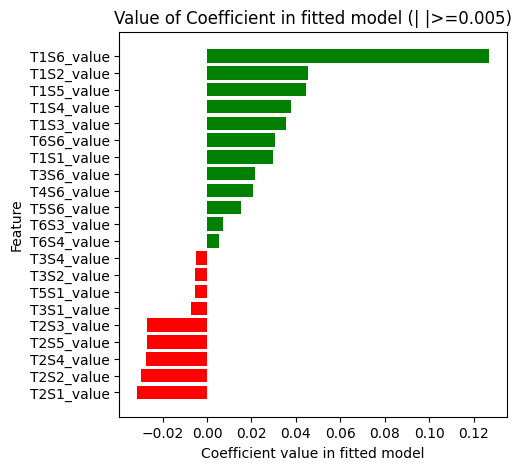

In [140]:
plt.figure(figsize=(5,5))
plt.barh(x,y,color=colors)
plt.yticks()
plt.title("Value of Coefficient in fitted model (| |>=0.005)")
plt.xlabel("Coefficient value in fitted model")
plt.ylabel("Feature")
plt.show()